In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error

In [2]:
## DATA ##

file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastspec-everest-sv1-bright.fits"
data=Table.read(file_path,hdu=1)
snr=data["HALPHA_EW"]*np.sqrt(data["HALPHA_EW_IVAR"])
data

TARGETID,CONTINUUM_Z,CONTINUUM_COEFF [11],CONTINUUM_CHI2,CONTINUUM_AGE,CONTINUUM_AV,CONTINUUM_AV_IVAR,CONTINUUM_VDISP,CONTINUUM_VDISP_IVAR,CONTINUUM_SNR_B,CONTINUUM_SNR_R,CONTINUUM_SNR_Z,CONTINUUM_SMOOTHCORR_B,CONTINUUM_SMOOTHCORR_R,CONTINUUM_SMOOTHCORR_Z,DN4000,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_MODEL_G,FLUX_SYNTH_MODEL_R,FLUX_SYNTH_MODEL_Z,BALMER_Z,FORBIDDEN_Z,BROAD_Z,BALMER_SIGMA,FORBIDDEN_SIGMA,BROAD_SIGMA,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_CONT,MGII_2796_CONT_IVAR,MGII_2796_EW,MGII_2796_EW_IVAR,MGII_2796_FLUX_LIMIT,MGII_2796_EW_LIMIT,MGII_2796_CHI2,MGII_2796_NPIX,MGII_2803_AMP,MGII_2803_AMP_IVAR,MGII_2803_FLUX,MGII_2803_FLUX_IVAR,MGII_2803_BOXFLUX,MGII_2803_VSHIFT,MGII_2803_SIGMA,MGII_2803_CONT,MGII_2803_CONT_IVAR,MGII_2803_EW,MGII_2803_EW_IVAR,MGII_2803_FLUX_LIMIT,MGII_2803_EW_LIMIT,MGII_2803_CHI2,MGII_2803_NPIX,NEV_3346_AMP,NEV_3346_AMP_IVAR,NEV_3346_FLUX,NEV_3346_FLUX_IVAR,NEV_3346_BOXFLUX,NEV_3346_VSHIFT,NEV_3346_SIGMA,NEV_3346_CONT,NEV_3346_CONT_IVAR,NEV_3346_EW,NEV_3346_EW_IVAR,NEV_3346_FLUX_LIMIT,NEV_3346_EW_LIMIT,NEV_3346_CHI2,NEV_3346_NPIX,NEV_3426_AMP,NEV_3426_AMP_IVAR,NEV_3426_FLUX,NEV_3426_FLUX_IVAR,NEV_3426_BOXFLUX,NEV_3426_VSHIFT,NEV_3426_SIGMA,NEV_3426_CONT,NEV_3426_CONT_IVAR,NEV_3426_EW,NEV_3426_EW_IVAR,NEV_3426_FLUX_LIMIT,NEV_3426_EW_LIMIT,NEV_3426_CHI2,NEV_3426_NPIX,OII_3726_AMP,OII_3726_AMP_IVAR,OII_3726_FLUX,OII_3726_FLUX_IVAR,OII_3726_BOXFLUX,OII_3726_VSHIFT,OII_3726_SIGMA,OII_3726_CONT,OII_3726_CONT_IVAR,OII_3726_EW,OII_3726_EW_IVAR,OII_3726_FLUX_LIMIT,OII_3726_EW_LIMIT,OII_3726_CHI2,OII_3726_NPIX,OII_3729_AMP,OII_3729_AMP_IVAR,OII_3729_FLUX,OII_3729_FLUX_IVAR,OII_3729_BOXFLUX,OII_3729_VSHIFT,OII_3729_SIGMA,OII_3729_CONT,OII_3729_CONT_IVAR,OII_3729_EW,OII_3729_EW_IVAR,OII_3729_FLUX_LIMIT,OII_3729_EW_LIMIT,OII_3729_CHI2,OII_3729_NPIX,NEIII_3869_AMP,NEIII_3869_AMP_IVAR,NEIII_3869_FLUX,NEIII_3869_FLUX_IVAR,NEIII_3869_BOXFLUX,NEIII_3869_VSHIFT,NEIII_3869_SIGMA,NEIII_3869_CONT,NEIII_3869_CONT_IVAR,NEIII_3869_EW,NEIII_3869_EW_IVAR,NEIII_3869_FLUX_LIMIT,NEIII_3869_EW_LIMIT,NEIII_3869_CHI2,NEIII_3869_NPIX,HEI_3889_AMP,HEI_3889_AMP_IVAR,HEI_3889_FLUX,HEI_3889_FLUX_IVAR,HEI_3889_BOXFLUX,HEI_3889_VSHIFT,HEI_3889_SIGMA,HEI_3889_CONT,HEI_3889_CONT_IVAR,HEI_3889_EW,HEI_3889_EW_IVAR,HEI_3889_FLUX_LIMIT,HEI_3889_EW_LIMIT,HEI_3889_CHI2,HEI_3889_NPIX,H6_AMP,H6_AMP_IVAR,H6_FLUX,H6_FLUX_IVAR,H6_BOXFLUX,H6_VSHIFT,H6_SIGMA,H6_CONT,H6_CONT_IVAR,H6_EW,H6_EW_IVAR,H6_FLUX_LIMIT,H6_EW_LIMIT,H6_CHI2,H6_NPIX,HEPSILON_AMP,HEPSILON_AMP_IVAR,HEPSILON_FLUX,HEPSILON_FLUX_IVAR,HEPSILON_BOXFLUX,HEPSILON_VSHIFT,HEPSILON_SIGMA,HEPSILON_CONT,HEPSILON_CONT_I

In [15]:
## getting good data of size n
file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastphot-everest-sv1-bright.fits"
data2=Table.read(file_path,hdu=1)
data3=Table.read(file_path,hdu=2)
#lines=["OII_3726_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW","NII_6584_EW","SII_6716_EW","SII_6731_EW"]
lines=["OII_3726_EW"]
#lines=["HALPHA_EW"]
N=len(data["TARGETID"])
for line in lines:
    n=50*10**3
    positions=[]
    for i in range(N):
        k=0
        # if snr[i]<1:
        #     k+=1
        if data[line][i]==0:
            k+=1
        if data2["KCORR_SDSS_U"][i]==0:
            k+=1
        if k==0:
            positions.append(i)
    print(len(positions))

    #magnitude_names=["FLUX_SYNTH_MODEL_G","FLUX_SYNTH_MODEL_R","FLUX_SYNTH_MODEL_Z","FLUX_SYNTH_MODEL_W1","FLUX_SYNTH_MODEL_W2"]
    #magnitude_names=["KCORR_SDSS_U","KCORR_SDSS_G","KCORR_SDSS_R","KCORR_SDSS_I","KCORR_SDSS_Z"]
    magnitude_names=["ABSMAG_SDSS_U","ABSMAG_SDSS_G","ABSMAG_SDSS_R","ABSMAG_SDSS_I","ABSMAG_SDSS_Z"]
    #jj=random.sample(range(0,len(positions)),n)
    jj=np.arange(n)
    EW=np.zeros(n)
    ivar=np.zeros(n)
    target_ids=np.zeros(n,int)
    magnitudes=np.zeros([n,len(magnitude_names)])

    for i in range(n):
        target_ids[i]=data["TARGETID"][positions[jj[i]]]
        EW[i]=data[line][positions[jj[i]]]
        ivar[i]=data[line+"_IVAR"][positions[jj[i]]]
        for j in range(len(magnitude_names)):
            magnitudes[i,j]=data2[magnitude_names[j]][positions[jj[i]]]
            

    # with open("/global/homes/a/ashodkh/results/target_ids.txt",'w') as f:    
    #     for i in range(n):
    #         f.write(str(target_ids[i])+"\n")
            
    ones=np.ones([n,1])
    x=np.zeros([n,len(magnitude_names)-1])
    for i in range(n):
        for j in range(len(magnitude_names)-1):
            x[i,j]=magnitudes[i,j]-magnitudes[i,j+1]
    x=np.concatenate((ones,x),axis=1)

    av_x=np.zeros(x.shape[1]-1)
    std_x=np.zeros(x.shape[1]-1)
    for i in range(1,x.shape[1]):
        av_x[i-1]=np.average(x[:,i])
        std_x[i-1]=np.std(x[:,i])
        x[:,i]=(x[:,i]-av_x[i-1])/std_x[i-1]


    N_cv=10
    x_split=np.split(x,N_cv)
    EW_split=np.split(EW,N_cv)
    ivar_split=np.split(ivar,N_cv)
    EW_fit_all=[]
    EW_obs_all=[]
    ivar_all=[]
    spearman_all=[]
    rms_all=[]
    nmad_all=[]
    nmad2_all=[]
    alpha=0.006
    for i in range(N_cv):
        x_valid=x_split[i]
        EW_valid=EW_split[i]
        ivar_valid=ivar_split[i]
        x_to_combine=[]
        EW_to_combine=[]
        for j in range(N_cv):
            if j!=i:
                x_to_combine.append(x_split[j])
                EW_to_combine.append(EW_split[j])
        x_train=np.concatenate(tuple(x_to_combine),axis=0)
        EW_train=np.concatenate(tuple(EW_to_combine),axis=0)
        nl=100
        tree=KDTree(x_train[:,:])
        dist, ind=tree.query(x_valid[:,:],k=nl)

        zeros=np.where(dist==0)[0]
        print(zeros)
        # for j in range(len(zeros)):
        dist=np.delete(dist,obj=zeros,axis=0)
        ind=np.delete(ind,obj=zeros,axis=0)
        x_valid=np.delete(x_valid,obj=zeros,axis=0)
        EW_valid=np.delete(EW_valid,obj=zeros,axis=0)
        ivar_valid=np.delete(ivar_valid,obj=zeros,axis=0)
        n_valid=x_valid.shape[0]

        theta=np.zeros([n_valid,x.shape[1],1])
        W=np.zeros([n_valid,nl,nl])
        X=np.zeros([n_valid,nl,x.shape[1]])
        Y=np.zeros([n_valid,nl,1])
        for j in range(nl):
            W[:,j,j]=1/dist[:,j]
            #W[:,j,j]=1
            #W[:,j,j]=np.exp(-dist[:,j]/alpha)
            X[:,j,:]=x_train[ind[:,j],:]
            Y[:,j,0]=EW_train[ind[:,j]]
        a1=np.zeros([n_valid,x.shape[1],1])
        a2=np.zeros([n_valid,x.shape[1],x.shape[1]])
        for ii in range(n_valid):
            a1[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],Y[ii,:,:]))
            a2[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],X[ii,:,:]))
            theta[ii,:,:]=np.matmul(np.linalg.inv(a2[ii,:,:]),a1[ii,:,:])
        EW_fit=np.zeros(n_valid)
        EW_used=np.zeros(n_valid)
        nmad=np.zeros(n_valid)
        nmad2=np.zeros(n_valid)
        for ii in range(n_valid):
            EW_fit[ii]=np.matmul(theta[ii,:,:].transpose(),x_valid[ii,:])
            EW_used[ii]=EW_valid[ii]
            nmad[ii]=np.abs(EW_fit[ii]-EW_used[ii])
            nmad2[ii]=np.abs(EW_fit[ii]-EW_used[ii])*np.sqrt(ivar_valid[ii])
        EW_fit_all.append(EW_fit)
        EW_obs_all.append(EW_used)
        ivar_all.append(ivar_valid)
        spearman_all.append(stats.spearmanr(EW_fit,EW_used)[0])
        rms_all.append(np.sqrt(mean_squared_error(EW_fit,EW_used)))
        nmad_all.append(1.48*np.median(nmad))
        nmad2_all.append(1.48*np.median(nmad2))

    print(spearman_all)
    print(np.average(spearman_all))
    print(rms_all)
    print(np.average(rms_all))
    print(nmad_all)
    print(np.average(nmad_all))
    print(nmad2_all)
    print(np.average(nmad2_all))

    

    #with open("/global/homes/a/ashodkh/results/logEW_fit_all_nl300_exp"+str(alpha)+".txt",'w') as f:
#     with open("/global/homes/a/ashodkh/results/EW_fit_1line_nl"+str(nl)+"_distance"+line+".txt",'w') as f:    
#         for i in range(N_cv):
#             for j in range(len(EW_fit_all[i])-1):
#                 f.write(str(np.round(EW_fit_all[i][j],decimals=5))+',')
#             f.write(str(np.round(EW_fit_all[i][-1],decimals=5)))
#             f.write('\n')
#     #with open("/global/homes/a/ashodkh/results/logEW_obs_all_nl300_exp"+str(alpha)+".txt",'w') as f:
#     with open("/global/homes/a/ashodkh/results/EW_obs_1line_nl"+str(nl)+"_distance"+line+".txt",'w') as f: 
#         for i in range(N_cv):
#             for j in range(len(EW_obs_all[i])-1):
#                 f.write(str(np.round(EW_obs_all[i][j],decimals=5))+',')
#             f.write(str(np.round(EW_obs_all[i][-1],decimals=5)))
#             f.write('\n')

#     with open("/global/homes/a/ashodkh/results/EW_1line_ivar"+line+".txt",'w') as f: 
#         for i in range(N_cv):
#             for j in range(len(ivar_all[i])-1):
#                 f.write(str(np.round(ivar_all[i][j],decimals=5))+',')
#             f.write(str(np.round(ivar_all[i][-1],decimals=5)))
#             f.write('\n')

115885
[ 181 4330 4330 4330]
[2348 2447 2447 2447 2447 4052 4052 4052]
[1147 1147 1147 4460]
[ 179  179  179  179 1179 1179 1179 4661 4661 4661]
[ 482  482  482  482 4786 4786 4786]
[3054 3054 3054 3054 4257 4257]
[1279 2178 2178 2178]
[ 386  934  934  934 1226 4241 4241 4241 4241]
[1112 1112 1112 1885]
[ 800  910 1300 4199 4199 4314 4314 4314 4840 4840]
[0.37837326666300114, 0.4873177933751352, 0.4168414328732258, 0.475504713795226, 0.4581625952998056, 0.4943705080543714, 0.41678585676034396, 0.49533750121417364, 0.5328101979065756, 0.5266706546558058]
0.46821745205976645
[471.80637099721133, 188.6129466938311, 958.0033297704678, 233.77504682882227, 4319.725619745147, 308.4964337911435, 285.0797990412397, 240.29287927650722, 380.3347310822435, 312.51126406207965]
769.8638421288694
[7.246591522170838, 7.13619665163986, 7.864727177270329, 7.384154937276996, 7.007894081291596, 7.220670738150411, 7.644621865306771, 6.598389206769379, 5.943135680498493, 7.009849229457212]
7.10562310898319


(-50.0, 200.0)

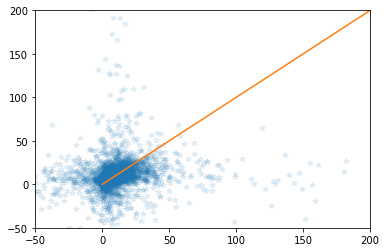

In [5]:
plt.plot(EW_obs_all[0],EW_fit_all[0],'*',alpha=0.1)
plt.plot(np.arange(0,200,0.1),np.arange(0,200,0.1))
plt.xlim((-50,200))
plt.ylim((-50,200))

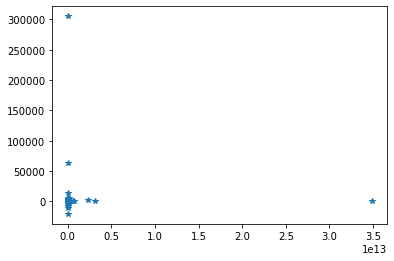

In [7]:
plt.plot(1/ivar,EW,'*')

34889108844313.305